## Goal: to create a library of visualization functions 

### Why?
* To make it EASY to create useful, well-designed, meaningful visualizations using seaborn
* To practice writing reusable, testable code

### admin

In [1]:
import os

import pandas as pd

import seaborn as sns
sns.set_context("talk")

from seaborn import plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
def get_data(csv_name, directory='processed'):
    '''Returns df of csv; defaults to processed data directory'''
    path = os.path.join(os.pardir, 'data', directory, csv_name)
    return pd.read_csv(path, encoding='utf-8')

def clear_fig():
    '''Clears fig object and resets sns context'''
    fig = plt.gcf()
    fig.clear();
    sns.set_context("talk")

## The data: New York Times Best Sellers List

* Scraped from Wikipedia & Goodreads
* Weekly list from 1942-2016

In [3]:
authors = get_data('authors.csv')
books = get_data('books.csv')

In [4]:
list(authors.columns)

['a_id',
 'a_fans_count',
 'a_works_count',
 'gender',
 'hometown',
 'a_avg_rating',
 'a_ratings_count',
 'a_text_reviews_count',
 'author',
 'a_wks_on_list',
 'a_books_on_list']

In [5]:
list(books.columns)

['b_id',
 'gr_title',
 'nyt_title',
 'b_count',
 'pub_yr',
 'b_avg_rating',
 'b_ratings_count',
 'b_txt_rev_count',
 'publisher',
 'b_rating_5_count',
 'b_rating_4_count',
 'b_rating_3_count',
 'b_rating_2_count',
 'b_rating_1_count',
 'b_wks_on_list',
 'decade',
 'a_id']

### What are you curious about?

If you were given this dataset, what would you do first? What questions do you have?

Write a list of questions here:

## EDA

Visualization is the quickest way to understand data quickly

Hurdle: _making_ nice visualizations _quickly_

Solution: functions!

### Tables

In [6]:
# answer one of our questions here using a table


#### Examples that might be useful

In [7]:
# top 10 authors with highest number of weeks on the NYT list
authors.sort_values('a_wks_on_list', ascending=False)[['author', 'a_wks_on_list']].head(10)

,author,a_wks_on_list
67,James A. Michener,200.0
126,Stephen King,144.0
128,John Grisham,139.0
92,James Patterson,102.0
226,Danielle Steel,94.0
236,Herman Wouk,91.0
153,Robert Ludlum,81.0
238,John le Carré,77.0
101,Dan Brown,75.0
127,Tom Clancy,74.0


In [8]:
# top 10 books with highest number of weeks on the NYT list
books.sort_values('b_wks_on_list', ascending=False)[['nyt_title', 'b_wks_on_list']].head(10)

,nyt_title,b_wks_on_list
325,The Da Vinci Code,59
254,Hawaii,49
496,The Caine Mutiny,48
661,The Robe,46
472,Love Story,41
247,The Source,40
678,The Bridges of Madison County,38
551,Jonathan Livingston Seagull,38
391,Trinity,36
84,The Spy Who Came in from the Cold,34


#### Let's make it abstract and resuable

In [9]:
# fill this in
def top_ten():
    '''What does this function do?'''
    return null

##### Version 1

In [10]:
def top_ten(df, label_col, value_col, num=10):
    '''Returns dataframe with 10 (by default) highest values in value_col'''
    return df.sort_values(value_col, ascending=False)[[label_col, value_col]].head(num)

In [11]:
top_ten(authors, 'author', 'a_wks_on_list')

,author,a_wks_on_list
67,James A. Michener,200.0
126,Stephen King,144.0
128,John Grisham,139.0
92,James Patterson,102.0
226,Danielle Steel,94.0
236,Herman Wouk,91.0
153,Robert Ludlum,81.0
238,John le Carré,77.0
101,Dan Brown,75.0
127,Tom Clancy,74.0


In [12]:
top_ten(books, 'nyt_title', 'b_wks_on_list')

,nyt_title,b_wks_on_list
325,The Da Vinci Code,59
254,Hawaii,49
496,The Caine Mutiny,48
661,The Robe,46
472,Love Story,41
247,The Source,40
678,The Bridges of Madison County,38
551,Jonathan Livingston Seagull,38
391,Trinity,36
84,The Spy Who Came in from the Cold,34


In [13]:
# this isn't going to work
top_ten(books.groupby('decade').count(), 'decade', 'nyt_title')

KeyError: "['decade'] not in index"

In [14]:
# fix it
top_ten(books.groupby('decade', as_index=False).count(), 'decade', 'nyt_title')

,decade,nyt_title
6,2000s,217
7,2010s,194
5,1990s,100
4,1980s,78
3,1970s,45
0,1940s,44
1,1950s,33
2,1960s,31


##### Version 2

In [15]:
def top_ten(df, column, index=True, num=10):
    '''Returns series indexed by df.index and 10 (by default) highest values of column'''
    if index != True:
        df = df.set_index(index)
    return df.sort_values(column, ascending=False)[column].head(num)

In [16]:
top_ten(books.groupby('decade').count(), 'nyt_title')

decade
2000s    217
2010s    194
1990s    100
1980s     78
1970s     45
1940s     44
1950s     33
1960s     31
Name: nyt_title, dtype: int64

##### Let's make this function accessible to our whole repo by moving it to a .py file.

In [17]:
# this allows jupyter notebook to import a module from up the directory structure
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [18]:
from src.visualization import visualize as v

In [19]:
v.top_ten(books.groupby('publisher').mean(), 'b_avg_rating')

publisher
DAW Books                 4.570
Open Road Media           4.530
Scholastic                4.520
Roc                       4.495
Amy Einhorn Books         4.450
Arthur A. Levine Books    4.430
Crown                     4.390
Scholastic Inc.           4.360
Amereon Limited           4.340
Piatkus                   4.290
Name: b_avg_rating, dtype: float64

In [20]:
v.top_ten(books.groupby('publisher').count(), 'nyt_title')

publisher
Unknown                     147
Little Brown & Co            48
Berkley                      43
Bantam                       33
G.P. Putnam's                29
Grand Central Publishing     28
Harper Collins               19
Random House                 18
Warner                       17
Pocket                       16
Name: nyt_title, dtype: int64

In [21]:
v.top_ten(authors, 'a_works_count', 'author')

author
Agatha Christie        1905
Stephen King           1260
Neil Gaiman            1062
George R.R. Martin      744
Nora Roberts            652
W. Somerset Maugham     560
Ernest Hemingway        543
James Patterson         498
Umberto Eco             483
Louis L'Amour           465
Name: a_works_count, dtype: int64

How can we check that this function works the way we expect it to?

### Bar charts

#### Examples of bar charts that might be useful

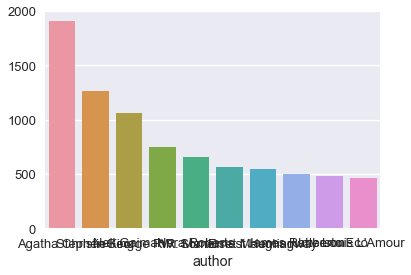

In [22]:
# top ten authors by number of works
top_ten_author_works = v.top_ten(authors, 'a_works_count', 'author')
ax = sns.barplot(x=top_ten_author_works.index, y=top_ten_author_works.values)

# rotate long labels
#plt.xticks(rotation=45);

# align labels with bars
#plt.xticks(ha='right');

# or pass kwargs to set_xticklabels
#ax.set_xticklabels(labels=top_ten_author_works.index, rotation=45, ha='right');

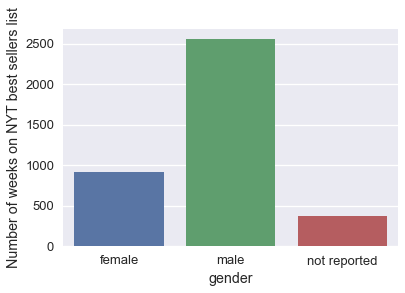

In [23]:
# weeks spent on the list by gender
wks_by_gender = authors.groupby('gender', as_index=False).sum()[['gender', 'a_wks_on_list']]
ax = sns.barplot(x='gender', y='a_wks_on_list', data=wks_by_gender)

# label y-axis
ax.set(ylabel='Number of weeks on NYT best sellers list');

#### Example of a well-designed bar chart

[Remove to improve (the data-ink ratio) by Darkhouse Analytics](http://www.darkhorseanalytics.com/blog/data-looks-better-naked)
* Reduce colors
* Remove backgrounds
* Remove borders
* Remove redundant labels
* Add direct labels

In [24]:
clear_fig();

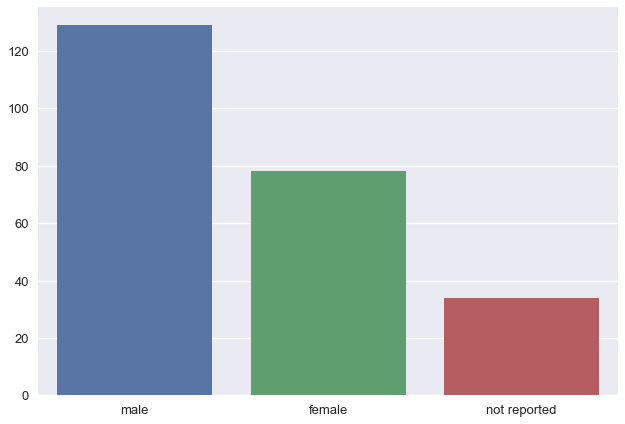

In [25]:
# number of authors by gender
authors_by_gender = authors['gender'].value_counts()
sns.barplot(x=authors_by_gender.index, y=authors_by_gender.values);

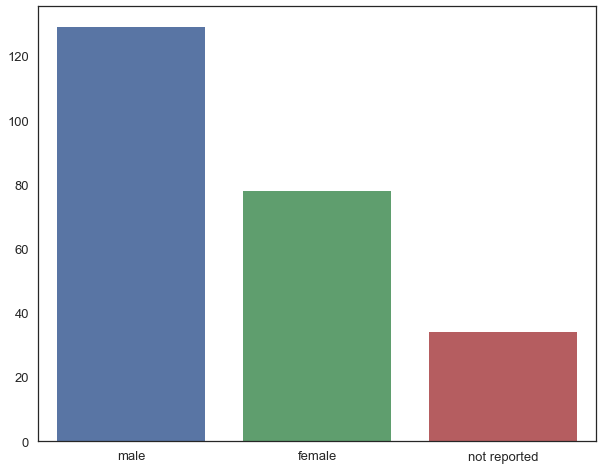

In [26]:
# remove backgrounds
sns.set_style('white')

# protip: need a figure object to show plot again in subsequent cells
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.barplot(x=authors_by_gender.index, y=authors_by_gender.values, ax=ax);

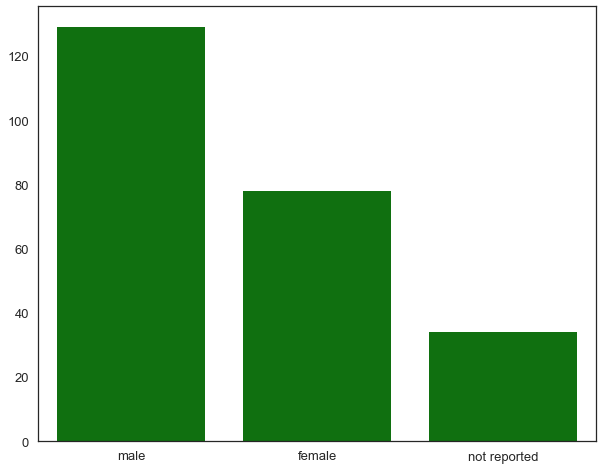

In [27]:
# creating a new figure because need to pass another argument to barplot
fig, ax = plt.subplots(figsize=(10,8))

# reduce colors
ax = sns.barplot(x=authors_by_gender.index, y=authors_by_gender.values, color='green', ax=ax);

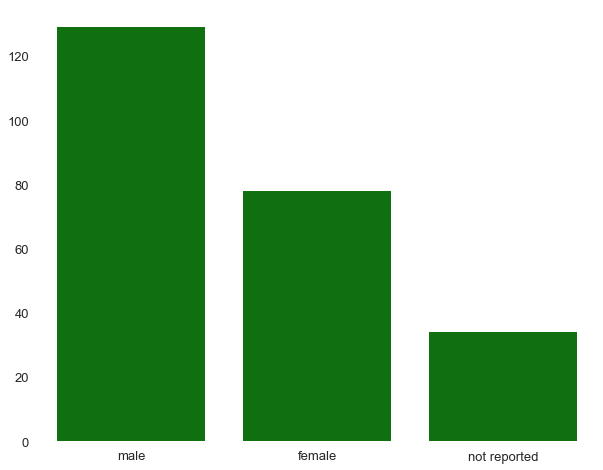

In [28]:
# remove borders
ax.set_frame_on(False)
fig

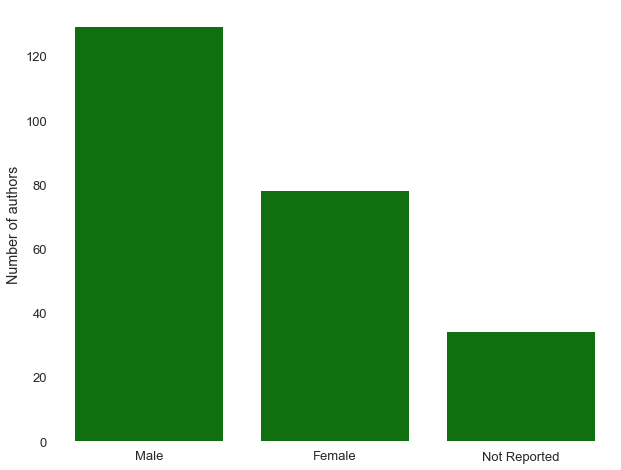

In [29]:
# add/format axes labels
ax.set_ylabel('Number of authors')
ax.set_xlabel('')
ax.set_xticklabels([label.title() for label in authors_by_gender.index])
fig

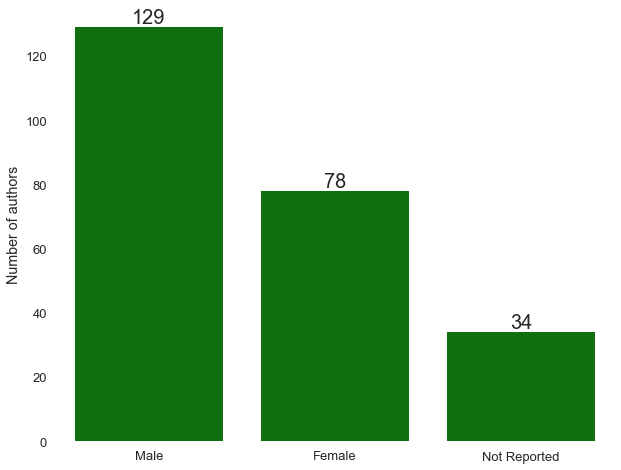

In [30]:
# add direct labels - label each bar with y value
labels = authors_by_gender.values
y_margin = max(labels) * 0.01

for bar, label in zip(ax.patches, labels):
    #x location of label
    x = bar.get_x()
    bar_width = bar.get_width()
    center = x + bar_width/2.0

    #y location of label
    bar_height = bar.get_height()
    
    ax.text(x=center, y=bar_height + y_margin, s=label, ha='center', size='20')    

fig

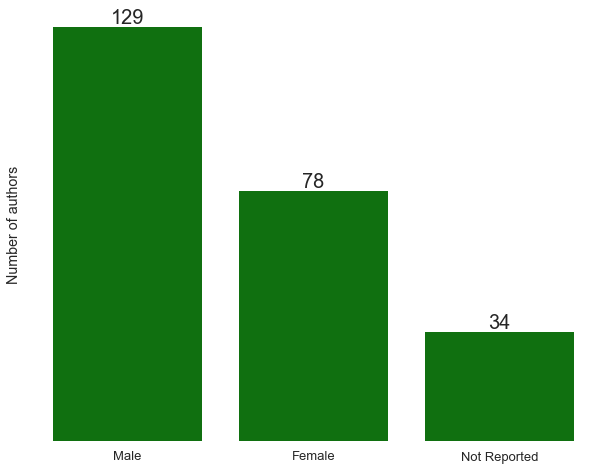

In [31]:
# remove redundant labels
ax.set_yticklabels([])
fig

##### Let's make it abstract and reusable

One function of different parts of the figure
* empty figure/axes
* axes labels --> depend on axes
* x-ticks labels --> depend on data
* direct labels on bars --> depend on data

###### Empty figures/axes

In [32]:
def create_empty_fig(xlabel='', ylabel=''):
    '''Returns empty Tufte-style fig, ax objects'''
    # create figures and axes objects to modify
    # fig controls figure-level settings (across group of subplots)
    # ax controls axis-level settings (across each subplot)
    fig, ax = plt.subplots(figsize=(10,8))
    
    # remove square outline
    ax.set_frame_on(False)
    
    return fig, ax

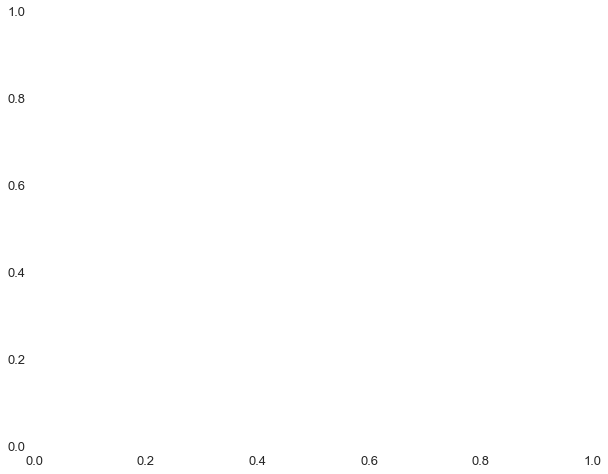

In [33]:
fig, ax = create_empty_fig()

###### Labels that depends on axis object

In [34]:
def set_axes_labels(ax, xlabel='', ylabel=''):
    '''Adds axes labels'''
    # add labels for axes
    ax.set(xlabel=xlabel, ylabel=ylabel)
    return ax

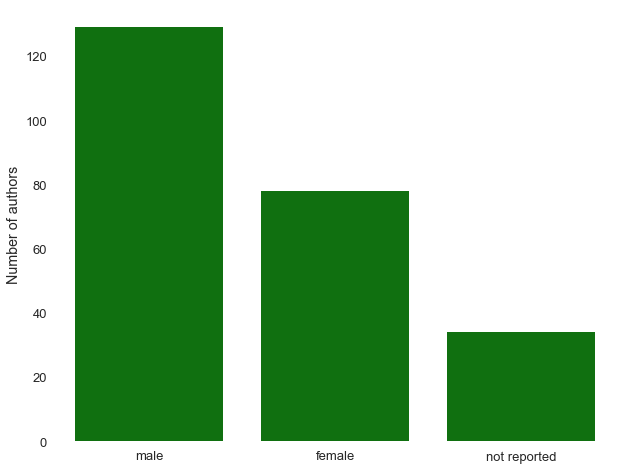

In [35]:
# note: data is a series
sns.barplot(x=authors_by_gender.index, y=authors_by_gender.values, color="green", ax=ax)
ax = set_axes_labels(ax, ylabel='Number of authors')
fig

###### Labels that depends on data

In [36]:
def format_xticks(data, ax, xticks=True, xticksrotate=False):
    '''Formats xtick labels to title case if True, removes xtick labels if False'''
    if (xticks == True and xticksrotate == False):
        ax.set_xticklabels([label.title() for label in data.index])
        
    elif (xticks == True and xticksrotate == True):
        ax.set_xticklabels([label.title() for label in data.index], rotation=45, ha='right')
    
    elif (xticks == False):
        ax.set_xticklabels([])
    
    return ax

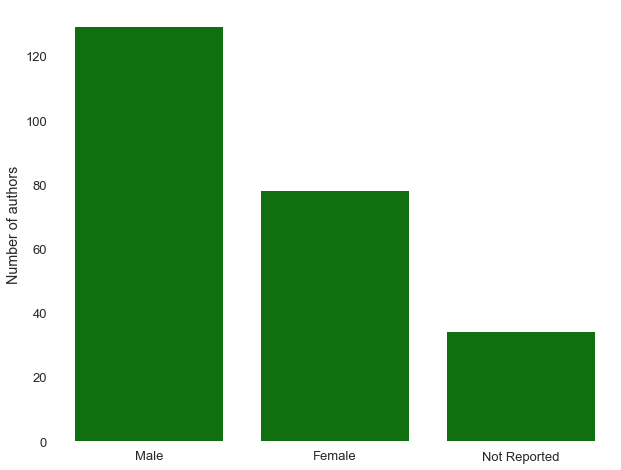

In [37]:
ax = format_xticks(authors_by_gender, ax)
fig

In [38]:
# add direct labels
def add_bar_labels(data, ax):
    '''Removes y-axis label and adds direct labels to tops of bars of sns barplot'''
    # remove y axis tick labels
    ax.set_yticklabels([])
    
    # label each bar with y value
    labels = data.values 
    y_margin = max(labels) * 0.01
    for bar, label in zip(ax.patches, labels):
        #x location of label
        x = bar.get_x()
        bar_width = bar.get_width()
        center = x + bar_width/2.0

        #y location of label
        bar_height = bar.get_height()

        ax.text(x=center, y=bar_height + y_margin, s=label, ha='center', size=20)

    return ax

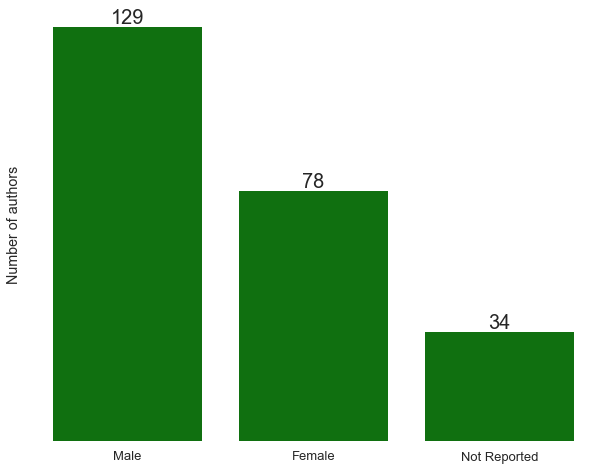

In [39]:
ax = add_bar_labels(authors_by_gender, ax)
fig

##### Let's make these functions accessible to our whole repo by moving it to a .py file.

How can we check that this function works the way we expect it to?

#### Example of a meaningful bar chart

How would you interpret the graph above? What would you want the audience to take away?

Write a list of interpretations here:

Drive your message home with your visualization!
* Highlight the bar with the highest value
* Add a meaningful title

In [40]:
# dataset is number of authors by gender
data = authors['gender'].value_counts()

# color palette
highlight = 'green'
standard = 'grey'

colors = [standard if (value < max(data.values)) else highlight for value in data.values]
list(zip(data, colors))

[(129, 'green'), (78, 'grey'), (34, 'grey')]

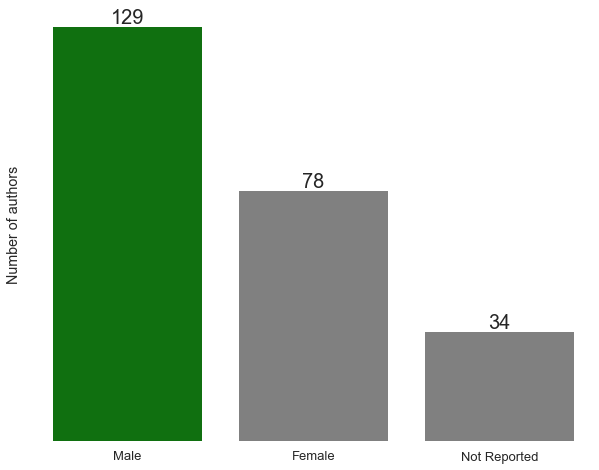

In [41]:
# create the plot
fig, ax = v.create_empty_fig()
sns.barplot(x=data.index, y=data.values, palette=colors, ax=ax)

ax = v.set_axes_labels(ax, ylabel='Number of authors')
ax = v.format_xticks(authors_by_gender, ax)
ax = v.add_bar_labels(authors_by_gender, ax)

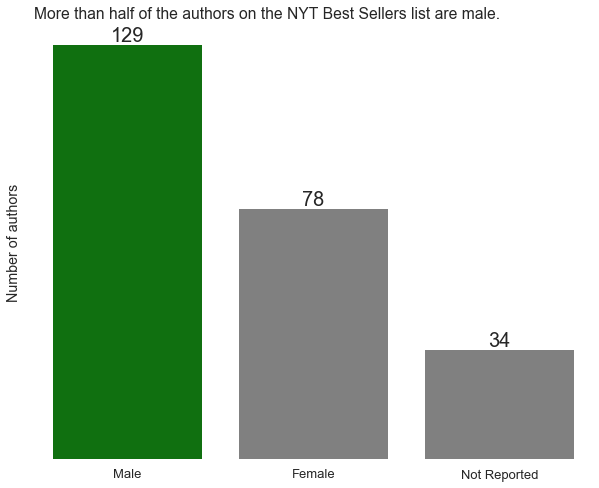

In [42]:
# add a meaningful title
ax.set_title('More than half of the authors on the NYT Best Sellers list are male.', loc='left')
fig

##### Let's make it abstract and resuable

In [43]:
def highlight_max(data, highlight, standard):
    '''Return list of colors, with index of maximum value in data set to highlight color'''
    return [highlight if (x == max(data.values)) else standard for x in data.values]

In [44]:
def bar_chart(data, highlight='grey', standard='grey', xlabel='', ylabel='', title='', xticksrotate=False):
    '''
    Creates Tufte-style bar chart 
    Set highlight to string of color to highlight highest value bar
    Note: data is a series with labeled indices
    '''
    # create empty fig, ax
    fig, ax = create_empty_fig()

    # draw plot bar
    colors = highlight_max(data, highlight, standard)
    ax = sns.barplot(x=data.index, y=data.values, palette=colors, ax=ax)
    
    ax = set_axes_labels(ax, xlabel=xlabel, ylabel=ylabel)
    
    # format xtick labels    
    ax = format_xticks(data, ax, xticksrotate=xticksrotate)

    # add labels on top of bars
    ax = add_bar_labels(data, ax)
    
    # add a meaningful title
    ax.set_title(title, loc='left')
    
    return fig, ax

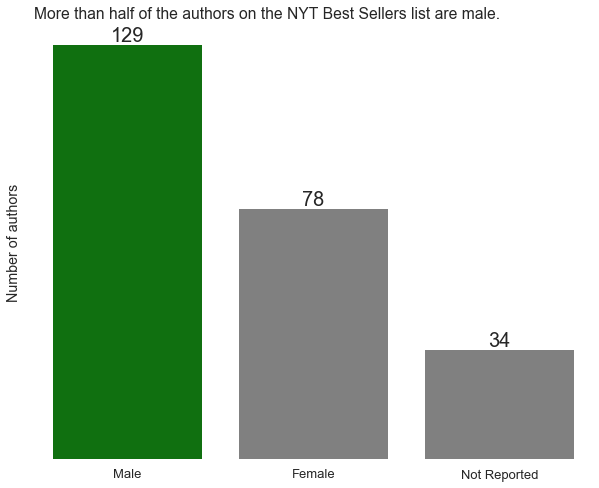

In [45]:
# create the plot
ylabel='Number of authors'
title = 'More than half of the authors on the NYT Best Sellers list are male.'
bar_chart(authors_by_gender, highlight='green', ylabel=ylabel, title=title);

gender
female           910.0
male            2553.0
not reported     379.0
Name: a_wks_on_list, dtype: float64


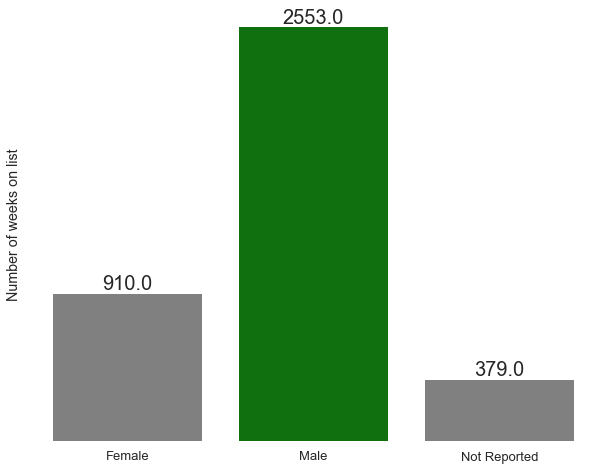

In [46]:
# dataset is number of weeks on nyt gender of author
wks_by_gender = authors.groupby('gender').sum()['a_wks_on_list']
print(wks_by_gender)

bar_chart(wks_by_gender, highlight='green', ylabel='Number of weeks on list');

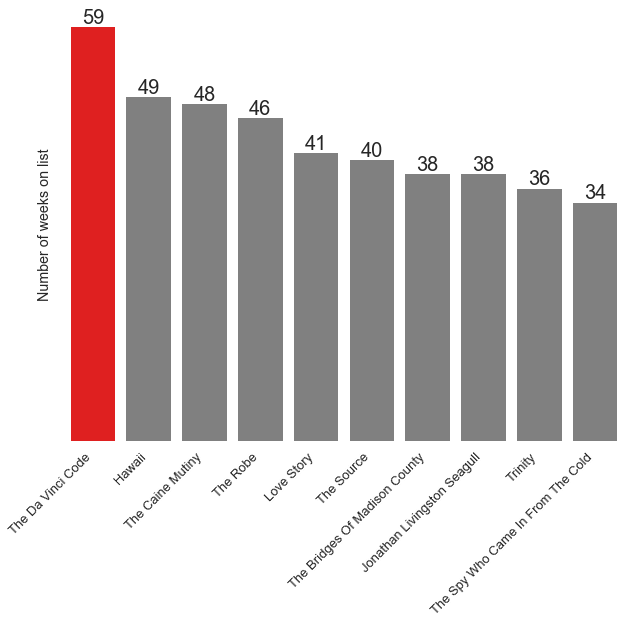

In [47]:
books_by_wks = v.top_ten(books, 'b_wks_on_list', index='nyt_title')
bar_chart(books_by_wks, ylabel='Number of weeks on list', xticksrotate=True, highlight='red');

##### Let's make these functions accessible to our whole repo by moving it to a .py file.

How can we check that this function works the way we expect it to?

### Line chart

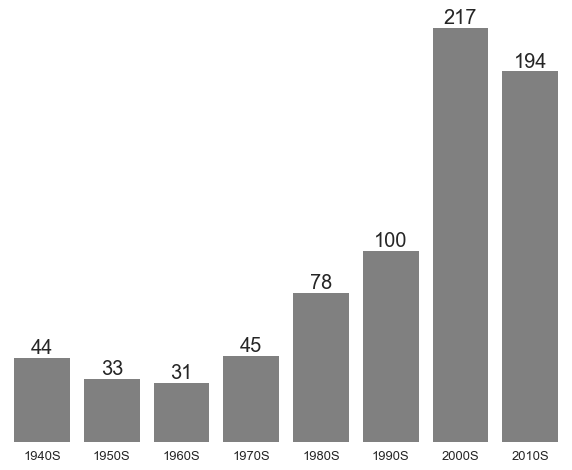

In [49]:
decades = v.top_ten(books.groupby('decade').count(), 'nyt_title').sort_index()
v.bar_chart(decades);

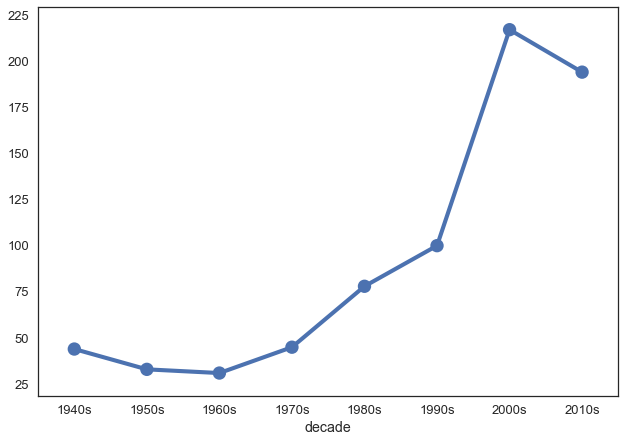

In [50]:
sns.pointplot(decades.index, decades.values);

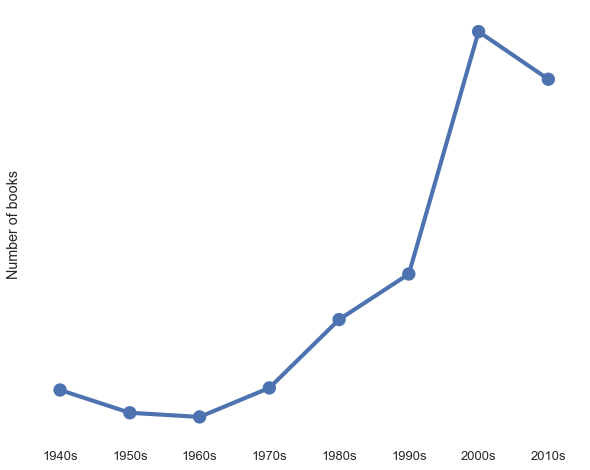

In [51]:
fig, ax = v.create_empty_fig()
sns.pointplot(decades.index, decades.values, ax=ax)
set_axes_labels(ax, xlabel='', ylabel='Number of books')
ax.set_yticks([]);

We're on our way!